<div style="text-align: center;">

<img src="https://img.freepik.com/vecteurs-premium/drapeau-officiel-jeux-olympiques-organisation-internationale-illustration-vectorielle_500695-998.jpg" style="width: 50%;"/>

# Olympic Dataset Analysis (1896-2016)
</div>

<b>Description</b><br><br>
This project aims to conduct an in-depth analysis of the Olympic Games dataset spanning from 1896 to 2016. The analysis will cover various aspects, including the influence of different factors on medal counts such as the type of games (Winter vs. Summer), team vs. individual sports, gender, age, economic indicators, and the impact of the host country.

<b>Objectives</b><br>

* Examine trends and patterns in medal counts over time and across different Olympic Games.
* Analyze how demographic factors like gender and age affect performance.
* Investigate the influence of economic factors (e.g., GDP, population) on medal achievements.
* Explore differences between team sports and individual sports.
* Assess the impact of hosting the Olympics on a country's medal performance.

<b>Data Description</b><br><br>
<b>Features</b>

* ID - Unique number for each athlete
* Name - Athlete's name
* Sex - Athlete's sex, M or F
* Age - Athlete's age, Integer
* Height - In centimeters
* Weight - In kilograms
* Team - Team name
* NOC - National Olympic Committee 3-letter code
* Games - Year and season
* Year - Integer
* Season - Summer or Winter
* City - Host city
* Sport - Sport
* Event - Event
* Medal - Gold, Silver, Bronze, or NA
* Region - Name of country
* GDP: GDP of the country.
* Population: Population of the country.

<b>Data Sources</b><br>
* Official Olympic data.<a href="https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results/data">[1]</a>
* Data for GDP and Population.<a href="https://databank.worldbank.org/reports.aspx?source=2&series=NY.GDP.MKTP.CD&country">[2]</a> <a href="https://databank.worldbank.org/reports.aspx?source=2&series=SP.POP.TOTL&country=">[3]</a>




## Table of Contents

- [Understanding and Preparing Data](#1)
- [Medal Success Rate by Country](#2)
- [Medal Success by Country](#3)
- [Medal Count of Countries by Time](#4)
- [The Relationship between Medal Success and Host](#5)
- [The Relationship between Medal Success and GDP and Population](#6)


In [1]:

# Import libraries

import pandas as pd
import numpy as np

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
from scipy.stats import mannwhitneyu


## Understanding and Preparing Data <a id='1' ></a>

In [2]:
# Load data
athletes = pd.read_csv('../data/raw/athlete_events.csv')
noc = pd.read_csv('../data/raw/noc_regions.csv')
gdp = pd.read_csv('../data/raw/gdp_of_countries.csv')
population = pd.read_csv('../data/raw/population_of_countries.csv')

In [3]:
def information_of_df(df):
    print("--------------------- Shape --------------------")
    print(df.shape)
    print("-------------------- Types ---------------------")
    print(df.dtypes)
    print("----------------- NaN Analysis -----------------")
    display(pd.concat([df.isna().sum()[df.isna().sum() != 0].sort_values(), 
           round(df.isna().sum()[df.isna().sum() != 0].sort_values() / df.shape[0] * 100, 2)],
          axis=1, keys=['Total Missing Values', 'Ratio'])
            )
    print("--------------------- Head ---------------------")
    display(df.head())

information_of_df(athletes)

--------------------- Shape --------------------
(271116, 15)
-------------------- Types ---------------------
ID          int64
Name       object
Sex        object
Age       float64
Height    float64
Weight    float64
Team       object
NOC        object
Games      object
Year        int64
Season     object
City       object
Sport      object
Event      object
Medal      object
dtype: object
----------------- NaN Analysis -----------------


,Total Missing Values,Ratio
Age,9474,3.49
Height,60171,22.19
Weight,62875,23.19
Medal,231333,85.33


--------------------- Head ---------------------


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


First I would like to detect <b>duplicate</b> rows and then remove them from the dataset.

In [4]:
display(athletes[athletes.duplicated()].head())
athletes = athletes.drop_duplicates()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
1252,704,Dsir Antoine Acket,M,27.0,NaN,NaN,Belgium,BEL,1932 Summer,1932,Summer,Los Angeles,Art Competitions,"Art Competitions Mixed Painting, Unknown Event",NaN
4282,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",NaN
4283,2449,William Truman Aldrich,M,48.0,NaN,NaN,United States,USA,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Painting, Drawings And ...",NaN
4862,2777,Hermann Reinhard Alker,M,43.0,NaN,NaN,Germany,GER,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Architecture, Designs F...",NaN
4864,2777,Hermann Reinhard Alker,M,43.0,NaN,NaN,Germany,GER,1928 Summer,1928,Summer,Amsterdam,Art Competitions,"Art Competitions Mixed Architecture, Architect...",NaN


There are many dirty variables in `Team` feature. In the past, it seems that some countries have sent special teams to the Olympic Games to represent the country. Therefore, I need to make a standard and change the name of these teams to the name of the country representing it. For this I will merge the dataframes on the NOC and replace the `Team` variables with `region` variables. However, the regions `Soviet Union`, `Czechoslovakia` and `Yugoslavia` are represented only by `Russia`, `Czech Republic` and `Serbia` respectively, so I will not replace these former countries in order not to ignore other countries like Belarus, Slovakia, Kazakhstan, etc.

In [5]:
exceptions = ["Soviet Union", "Czechoslovakia", "Yugoslavia"]

merged_df = pd.merge(athletes, noc, on='NOC', how='left')
merged_df['Team'] = merged_df.apply(
    lambda row: row['region'] if row['Team'] not in exceptions and pd.notna(row['region']) else row['Team'],
    axis=1
)

pattern = r'Singapore-\d+'
merged_df['Team'] = merged_df['Team'].str.replace(pattern, 'Singapore', regex=True)

# Reorder the columns to match the original athlete_data DataFrame
athletes_df = merged_df[athletes.columns].copy()

In [6]:
#after clean
athletes_df.Team.value_counts()

Team
USA             18604
Germany         15787
France          12551
UK              12115
Italy           10668
                ...  
Tuvalu              7
Rika II             4
South Sudan         3
June Climene        3
Unknown             2
Name: count, Length: 214, dtype: int64

I would like analyze whether the country hosting the games has an impact on the medal success of its athletes. Therefore I will update to `City` variables according to country it is connected to. 

In [7]:
city_country_map = {
    '(London)': 'UK',
    '(Athina)': 'Greece',
    '(Sydney|Melbourne)': 'Australia',
    '(Rio de Janeiro)': 'Brazil',
    '(Beijing)': 'China',
    '(Barcelona)': 'Spain',
    '(Seoul)': 'South Korea',
    '(Munich|Berlin|Garmisch-Partenkirchen)': 'Germany',
    '(Montreal|Calgary|Vancouver)': 'Canada',
    '(Mexico City)': 'Mexico',
    '(Helsinki)': 'Finland',
    "(Roma|Torino|Cortina d'Ampezzo)": 'Italy',
    '(Tokyo|Nagano|Sapporo)': 'Japan',
    '(Moskva)': 'Soviet Union',
    '(Paris|Albertville|Chamonix|Grenoble)': 'France',
    '(Amsterdam)': 'Netherlands',
    '(Stockholm)': 'Sweden',
    '(Antwerpen)': 'Belgium',
    '(Salt Lake City|St. Louis|Squaw Valley|Lake Placid|Los Angeles|Atlanta)': 'USA',
    '(Innsbruck)': 'Austria',
    '(Lillehammer|Oslo)': 'Norway',
    '(Sarajevo)': 'Yugoslavia',
    '(Sankt Moritz)': 'Switzerland',
    '(Sochi)': 'Russia'
    }

athletes_df['host_country'] = athletes_df['City'].replace(city_country_map, regex=True)
athletes_df.host_country.value_counts().index


Index(['USA', 'UK', 'Australia', 'Germany', 'Canada', 'Greece', 'Italy',
       'Brazil', 'China', 'Spain', 'Japan', 'France', 'South Korea', 'Mexico',
       'Finland', 'Soviet Union', 'Russia', 'Netherlands', 'Sweden', 'Belgium',
       'Norway', 'Austria', 'Yugoslavia', 'Switzerland'],
      dtype='object', name='host_country')

In [8]:
athletes_df['is_host'] = np.where(athletes_df['Team'] == athletes_df['host_country'], True, False)

The data set does not contain any information about team sports. This could create the impression that each athlete in the team individually won medals, which may lead to significant manipulation of the data set. Hence I will separate data according to team and individual games. However, before separating process, I want to fill the <b>nan</b> variables in the `Medal` feature `No Medal`.

In [9]:
athletes_df['Medal'] = athletes_df['Medal'].fillna('No Medal')

In [10]:
team_game_keywords = ["Team", "Relay","Two", "Double", "Duet", "Pairs", "Skiff", "Three Person", "Group", "Four", "Quadruple",
                      "Eights", "6-Man", "17-Man", "Polo", "Football", "Basketball", "Volleyball", "Baseball", "Handball",
                      "Softball", "Rugby", "Hockey", "Curling", "Tug-Of-War", "Sailing", "Synchronized", "Madison", "Ice Dancing"] 

individual_game_keywords = ["Individual", "Solo", "Single"]

# Filter DataFrames
athletes_of_team_games = athletes_df[athletes_df['Event']
                                     .apply(lambda event: any(keyword in event for keyword in team_game_keywords)
                                            and not any(keyword in event for keyword in individual_game_keywords))].copy()

athletes_of_individual_games = athletes_df[athletes_df['Event']
                                           .apply(lambda event: any(keyword in event for keyword in individual_game_keywords)
                                                  or not any(keyword in event for keyword in team_game_keywords))].copy()

Keelboat oyunu mixed ama hepsi M ->Sailing Mixed Three Person Keelboat : Sailing Mixed Two Person Keelboat

Luge Mixed (Men)'s Doubles, Mixed var ama görüldüğü üzere men takımı belirtilmiş. Muhtemelen oyun olarak mixed!

Sailing Mixed 12 metres, mixed ama hiç kadın atlet yok!

Sailing Mixed Two Person Heavyweight Dinghy, mixed ama hiç kadın atlet yok!

In [11]:
# pattern = r'\b(mixed|Midex)\b'

# # Filter the DataFrame
# athletes_of_team_games[athletes_of_team_games['Event'].str.contains(pattern, regex=True, case=False)].query('Medal != "No Medal"')['Event'].value_counts()

In [12]:
athletes_of_team_games.loc[:, 'type_of_event'] = 'team_games'
athletes_of_individual_games.loc[:, 'type_of_event'] = 'individual_games'

In [13]:
athletes_of_team_games = athletes_of_team_games.drop_duplicates(subset=['Medal','Team', 'Event', 'Games'])
athletes_for_both_games = pd.concat([athletes_of_individual_games, athletes_of_team_games], axis=0, ignore_index=True)

In [25]:
# athletes_for_both_games.query('Medal != "No Medal"').to_csv('../data/processed/medal-winning_athletes_and_teams.csv', index=False)

Let's confirm the accuracy of the cleaned data with the results of the 2016 Olympic Games.<a href="https://en.wikipedia.org/wiki/2016_Summer_Olympics_medal_table">[4]</a>

In [15]:
# Create the pivot table
year = 2016
pivot_table = pd.pivot_table(
    athletes_for_both_games.query('Medal != "No Medal" and Year==@year'),
    index='Team', columns='Medal', aggfunc='size', fill_value=0
)[['Gold', 'Silver', 'Bronze']].sort_values(by=['Gold', 'Silver', 'Bronze'], ascending=[False, False, False]).reset_index()

pivot_table.index = pivot_table.index + 1
pivot_table.index.name = 'Rank'


# Style the DataFrame
styled_df = (pivot_table[['Team', 'Gold', 'Silver', 'Bronze']]
             .iloc[:15]
             .style.set_caption(f'Medals by Country: Olympic Games {(year)} sorted by Gold Medals [Top 15]')
             .bar(subset=['Gold'], color='#FFD700')
             .bar(subset=['Silver'], color='#C0C0C0')
             .bar(subset=['Bronze'], color='#CD7F32')
             .set_table_styles({
                 'index': [{'selector': 'td:hover', 'props': 'visibility: hidden;'}],
                 'index_name': [{'selector': 'td:hover', 'props': 'visibility: hidden;'}]
             })
             .set_properties(**{'text-align': 'left'})
             )
styled_df

Medal,Team,Gold,Silver,Bronze
Rank,,,,
1,USA,46,37,38
2,UK,27,23,17
3,China,26,18,26
4,Russia,19,17,20
5,Germany,17,10,15
6,Japan,12,8,21
7,France,10,18,14
8,South Korea,9,3,9
9,Italy,8,12,8


## Medal Success Rate by Country <a id='2' ></a>

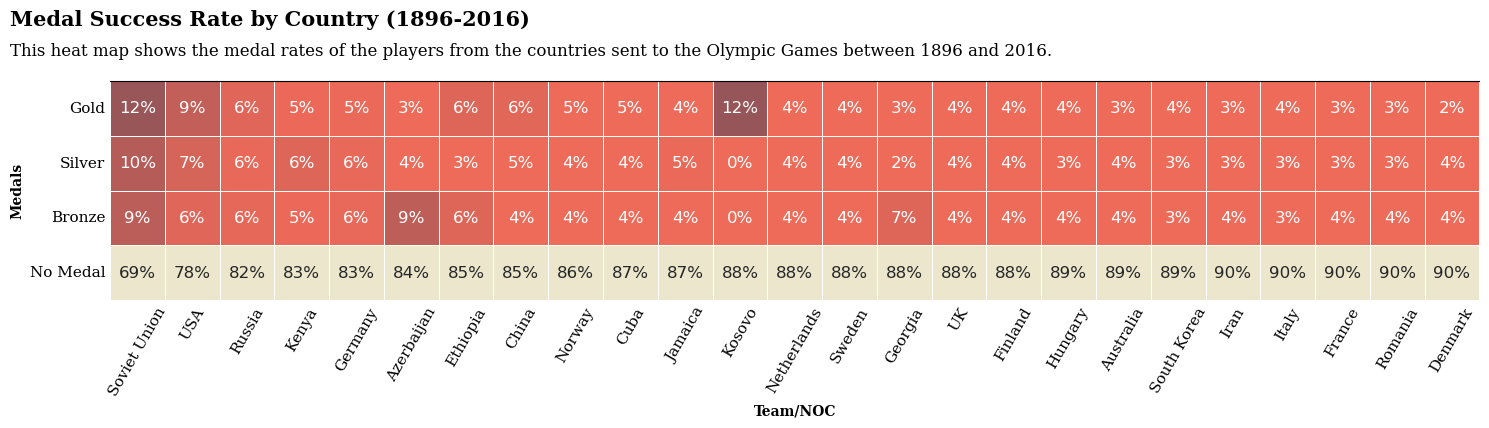

In [16]:
def medal_success_rate(df):
    
    cross_table = pd.crosstab(df['Team'],
                              df['Medal'],
                              normalize = "index").T
    
    medals = ['Gold','Silver','Bronze','No Medal']
    teams = cross_table.loc['No Medal'].sort_values().head(25).index
    
    cross_table = cross_table.loc[medals, teams]
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#EE6A59", "#3A3F58", "#F9AC67", "#ECE6CD"])

    fig, ax = plt.subplots(1, 1, figsize=(15, 15))

    sns.heatmap(cross_table, cmap=cmap, square=True, linewidth=0.5, cbar=False,
                annot=True, fmt='1.0%', vmax=.5, vmin=0.05, ax=ax, annot_kws={"fontsize":12})

    ax.spines['top'].set_visible(True)

    fig.text(0.01, 0.61, f"""Medal Success Rate by Country (1896-2016)""",
             fontweight='bold', fontfamily='serif', fontsize=15, ha='left')   
    fig.text(0.01, 0.59, """This heat map shows the medal rates of the players from the countries sent to the Olympic Games between 1896 and 2016."""
             , fontsize=12, fontfamily='serif', ha='left')

    ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation=0, fontsize=11)
    ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=60, fontsize=11)

    ax.set_ylabel('Medals',fontweight='bold',fontfamily='serif',fontsize=10)    
    ax.set_xlabel('Team/NOC',fontweight='bold',fontfamily='serif',fontsize=10)
    ax.tick_params(axis=u'both', which=u'both',length=0)
    plt.tight_layout()
    plt.show()

medal_success_rate(athletes_for_both_games)

## Medal Success by Country <a id='3' ></a>


In [17]:
# df = (
#     athletes_for_both_games
#     .query('Medal != "No Medal"')
#     .groupby(['Team', 'Season'])
#     .size()
#     .reset_index(name='count_medal')
#     .sort_values(by='count_medal', ascending=False)
# )

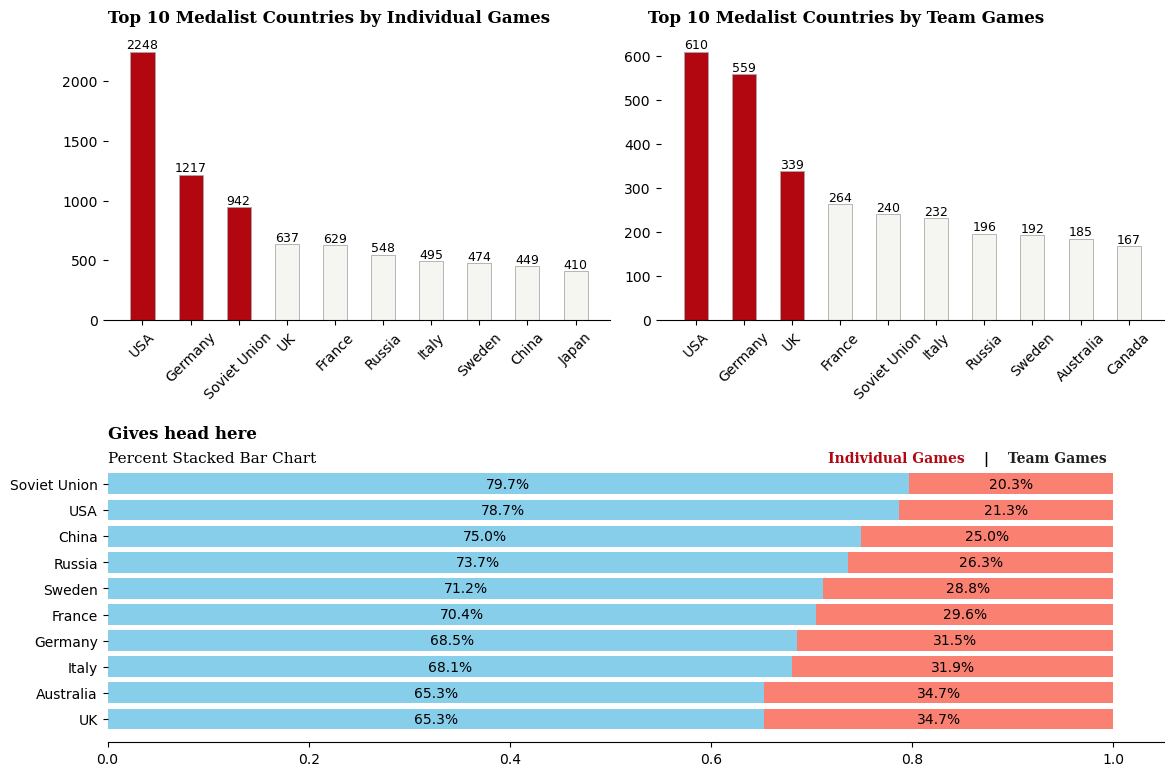

In [18]:
def plot_medal_analysis(df):
    # Data Preparation
    df_pivoted = (
        df.query('Medal != "No Medal"')
        .groupby(['Team', 'type_of_event'])
        .size()
        .reset_index(name='count_medal')
        .pivot(index='Team', columns='type_of_event', values='count_medal')
        .fillna(0)
    )
    
    df_pivoted['Total'] = df_pivoted.sum(axis=1)
        
    # Calculating the rates
    df_pivoted['individual_rate'] = df_pivoted['individual_games'] / df_pivoted[['individual_games', 'team_games']].sum(axis=1)
    df_pivoted['team_rate'] = df_pivoted['team_games'] / df_pivoted[['individual_games', 'team_games']].sum(axis=1)

    df_for_individual_games = df_pivoted.sort_values(by='individual_games',ascending=False)[:10]
    df_for_team_games = df_pivoted.sort_values(by='team_games',ascending=False)[:10]
    df_for_rates = df_pivoted.sort_values(by='Total', ascending=False)[:10].sort_values(by='individual_rate')
    
    # Create a figure
    fig = plt.figure(figsize=(12, 8))

    # Create a gridspec layout
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])

    color_map = ['#f5f5f1' for _ in range(10)]
    color_map[0] = color_map[1] = color_map[2] = '#b20710'  # color highlight

    # Create subplots using gridspec
    ax0 = fig.add_subplot(gs[1, :])  # Full width of the second row
    ax1 = fig.add_subplot(gs[0, 0])  # Upper-left cell
    ax2 = fig.add_subplot(gs[0, 1])  # Upper-right cell

    # Plot horizontal stacked bar chart manually
    y = range(10)  # y-axis positions
    ax0.barh(y, df_for_rates['individual_rate'], color='skyblue', label='Individual Rate')
    ax0.barh(y, df_for_rates['team_rate'], left=df_for_rates['individual_rate'], color='salmon', label='Team Rate')

    # Add percentage labels
    for i, (individual, team) in enumerate(zip(df_for_rates['individual_rate'], df_for_rates['team_rate'])):
        ax0.text(individual / 2, i, f'{individual:.1%}', va='center', ha='center', color='black')
        ax0.text(individual + team / 2, i, f'{team:.1%}', va='center', ha='center', color='black')

    # Customize the plot
    ax0.set_yticks(y)
    ax0.set_yticklabels(df_for_rates.index)

    # Remove spines
    for ax in [ax0, ax1, ax2]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(True)  # Keep the bottom line
        ax.spines['left'].set_visible(False)
    
    # Plot other charts
    bars_ax1 = ax1.bar(df_for_individual_games.index, df_for_individual_games['individual_games'], width=0.5, 
                       edgecolor='darkgray', linewidth=0.6, color=color_map)
    bars_ax2 = ax2.bar(df_for_team_games.index, df_for_team_games['team_games'], width=0.5, 
                       edgecolor='darkgray', linewidth=0.6, color=color_map)

    for bar in bars_ax1:
        yval = int(bar.get_height())  # Convert float to integer
        ax1.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', 
                 va='bottom', ha='center', color='black', fontsize=9)  # Adjust font size

    for bar in bars_ax2:
        yval = int(bar.get_height())  # Convert float to integer
        ax2.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval}', 
                 va='bottom', ha='center', color='black', fontsize=9)  # Adjust font size

    # Rotate x-axis labels for ax1 and ax2
    ax1.tick_params(axis='x', rotation=45)
    ax2.tick_params(axis='x', rotation=45)

    # Add main title using fig.text()
    fig.text(0.1, 1, 'Top 10 Medalist Countries by Individual Games', 
             fontsize=12, fontweight='bold', fontfamily='serif', ha='left')
    fig.text(0.55, 1, 'Top 10 Medalist Countries by Team Games', 
             fontsize=12, fontweight='bold', fontfamily='serif', ha='left')
    fig.text(0.1, 0.48, 'Gives head here', 
             fontsize=12, fontweight='bold', fontfamily='serif', ha='left')
    fig.text(0.1, 0.45, 'Percent Stacked Bar Chart', 
             fontsize=11, fontfamily='serif', ha='left')
    fig.text(0.70,0.45,"Individual Games", fontweight="bold", fontfamily='serif', fontsize=10, color='#b20710')
    fig.text(0.83,0.45,"|", fontweight="bold", fontfamily='serif', fontsize=10, color='black')
    fig.text(0.85,0.45,"Team Games", fontweight="bold", fontfamily='serif', fontsize=10, color='#221f1f')

    plt.subplots_adjust(left=0.1, right=0.98, top=0.98, bottom=0.1, wspace=0.1, hspace=0.5)
    plt.show()

plot_medal_analysis(athletes_for_both_games)

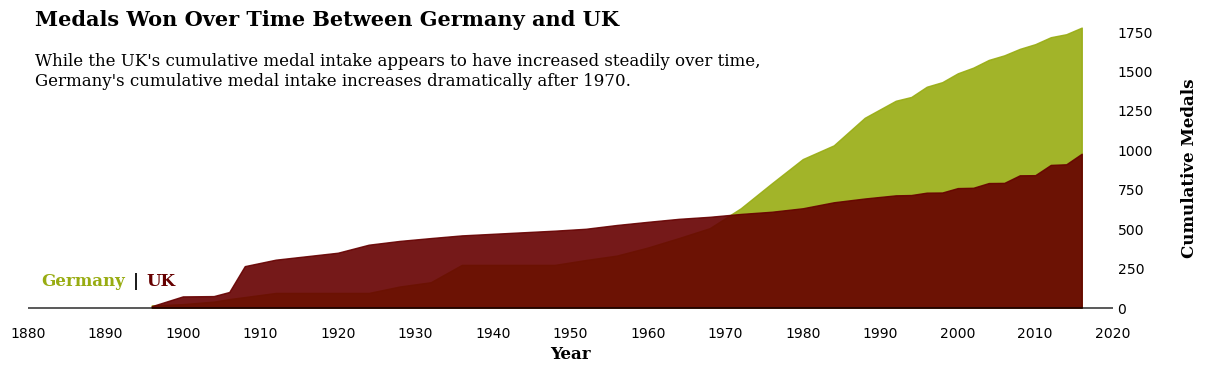

In [19]:
def plot_cumulative_medals(df, teams=['Germany', 'UK'], 
                           colors=['#98AC12', '#660000'],
                           xlim=(1880, 2020), xticks=np.arange(1880, 2021, 10)):
    """
    Plot cumulative medals won over time for specified teams.

    Parameters:
    - df: DataFrame containing 'Year', 'Team', and 'count_medal' columns.
    - teams: List of teams to include in the plot.
    - colors: List of colors for each team.
    - title: Main title of the plot.
    - subtitle: Subtitle text for the plot.
    - xlim: Tuple specifying the x-axis limits.
    - xticks: Array specifying the x-axis ticks.
    """
    
    # Filter and process data
    df_filtered = (
        df.query('Medal != "No Medal" and Team in @teams')
          .groupby(['Year', 'Team'])
          .size()
          .reset_index(name='count_medal')
    )
    
    df_grouped = df_filtered.groupby(['Year', 'Team'])['count_medal'].sum().unstack().fillna(0)
    df_cumsum = df_grouped.cumsum()

    fig, ax = plt.subplots(figsize=(14, 4))

    for i, team in enumerate(df_grouped.columns):
        ax.fill_between(df_cumsum.index, 0, df_cumsum[team], color=colors[i], label=team, alpha=0.9)

    ax.yaxis.tick_right()
    ax.axhline(y=0, color='black', linewidth=1.3, alpha=0.7)
    ax.spines[['top', 'right', 'bottom', 'left']].set_visible(False)
    ax.grid(False)

    ax.set_xlim(xlim) 
    plt.xticks(xticks)

    ax.set_xlabel('Year', fontsize=12, fontweight='bold', fontfamily='serif')
    ax.set_ylabel('Cumulative Medals', fontsize=12, fontweight='bold', fontfamily='serif', labelpad=20)
    ax.yaxis.set_label_position('right')

    title = f"""Medals Won Over Time Between {teams[0]} and {teams[1]}"""
    subtitle="""While the UK's cumulative medal intake appears to have increased steadily over time, 
Germany's cumulative medal intake increases dramatically after 1970."""

    fig.text(0.13, 0.85, title, fontsize=15, fontweight='bold', fontfamily='serif')
    fig.text(0.13, 0.70, subtitle, fontsize=12, fontweight='light', fontfamily='serif')

    fig.text(0.135, 0.2, "Germany", fontweight="bold", fontfamily='serif', fontsize=12, color='#98AC12')
    fig.text(0.20, 0.2, "|", fontweight="bold", fontfamily='serif', fontsize=12, color='black')
    fig.text(0.21, 0.2, "UK", fontweight="bold", fontfamily='serif', fontsize=12, color='#660000')

    ax.tick_params(axis='both', which='both', length=0)

    plt.show()

plot_cumulative_medals(athletes_for_both_games)

## Medal Count of Countries by Time <a id='4' ></a>

In [20]:
# test_data = (
#     athletes_for_both_games.query('Medal != "No Medal"').groupby(['Year', 'Team', 'Medal'])
#     .size().reset_index(name='count_medal').sort_values(by=['Year','count_medal'], ascending=[True, False])
# )

# countries_of_interest = ['USA', 'Greece', 'Germany', 'UK', 'France']
# gold_medals_data = test_data[(test_data['Team'].isin(countries_of_interest)) & (test_data['Medal'] == 'Gold')]


# test_pivot_table = gold_medals_data.pivot_table(
#     index=['Year', 'Team'],
#     columns='Medal',
#     values='count_medal',
#     fill_value=0,
#     aggfunc='sum'
# ).reset_index()

# # Ensure that columns are properly ordered
# test_pivot_table = test_pivot_table[['Year', 'Team', 'Gold']]

# plt.figure(figsize=(14, 8))

# # Plot each country
# for country in countries_of_interest:
#     country_data = test_pivot_table[test_pivot_table['Team'] == country]
#     plt.plot(country_data['Year'], country_data['Gold'], label=f'{country} Gold', marker='o')

# # Add labels and title
# plt.xlabel('Year')
# plt.ylabel('Number of Gold Medals')
# plt.title('Gold Medal Counts Over Time for Selected Countries')
# plt.legend(loc='best')
# plt.grid(True)

# # Show plot
# plt.show()

## The Relationship between Medal Success and Host <a id='5' ></a>

The relationship between medal-winning athletes and the country hosting the Games

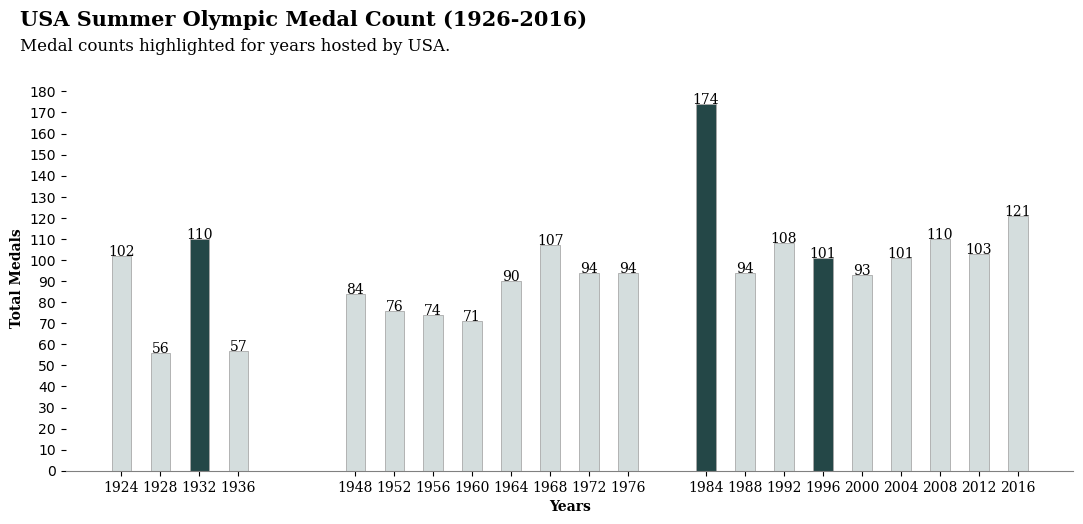

In [21]:
def plot_usa_medal_count(df):
    # Filter data for USA Summer Olympics after 1920 and medals won
    usa_data = (df
                .query('Medal != "No Medal" and Year > 1920 and Season == "Summer" and Team == "USA"')
                .groupby(['Year', 'host_country'])
                .size().reset_index(name='count_medal'))
    
    # Color map configuration: change color if host country is USA
    color_map = ['#d4dddd' if host != 'USA' else '#244747' for host in usa_data['host_country']]
    
    fig, ax = plt.subplots(figsize=(13, 5))
    ax.bar(usa_data['Year'], usa_data['count_medal'], color=color_map, width=2, edgecolor='darkgray', linewidth=0.6)
    
    for idx, row in usa_data.iterrows():
        ax.annotate(f"{row['count_medal']}", xy=(row['Year'], row['count_medal'] + 2), 
                    va='center', ha='center', fontweight='light', fontfamily='serif')
    
    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_color('gray')
    
    # Set x-ticks and labels
    ax.set_xticks(usa_data['Year'])
    ax.set_xticklabels(usa_data['Year'], fontfamily='serif', rotation=0)
    ax.set_xlabel("Year", fontsize=12, fontweight='light', fontfamily='serif', loc='left')
    
    # Title and subtitle
    fig.text(0.09, 1, 'USA Summer Olympic Medal Count (1926-2016)', fontsize=15, fontweight='bold', fontfamily='serif')
    fig.text(0.09, 0.95, 'Medal counts highlighted for years hosted by USA.', fontsize=12, fontweight='light', fontfamily='serif')
    
    # Set y-axis properties
    ax.set_yticks(np.arange(0, max(usa_data['count_medal']) + 10, 10))
    ax.set_ylabel('Total Medals', fontweight='bold', fontfamily='serif', fontsize=10)    
    ax.set_xlabel('Years', fontweight='bold', fontfamily='serif', fontsize=10)
    
    # Disable grid for a cleaner look
    ax.grid(False)
    
    plt.show()

plot_usa_medal_count(athletes_for_both_games)

To examine the relationship between whether a country is hosting the Olympics (indicated by `is_host`) and the number of medals they win (`count_medal`), we can use a non-parametric statistical test since the `count_medal` variable does not follow a normal distribution. One suitable test for this purpose is the `Mann-Whitney U test`<a href="https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test">[5]</a>, which compares the medians of two independent groups.

* <b>Null Hypothesis (H0):</b> There is no difference in the number of medals won by host countries and non-host countries.<br>
* <b>Alternative Hypothesis (H1):</b> There is a difference in the number of medals won by host countries and non-host countries.

In [22]:
def test_host_medal_relationship(data):
    
    # Split the data into two groups based on the `is_host` variable
    host_medals = data[data['is_host'] == True]['count_medal']
    non_host_medals = data[data['is_host'] == False]['count_medal']
    
    # Perform the Mann-Whitney U test
    stat, p_value = mannwhitneyu(host_medals, non_host_medals, alternative='two-sided')
    
    # Determine the result
    if p_value < 0.05:
        result = "Reject the null hypothesis: There is a significant difference in the number of medals won by host and non-host countries."
    else:
        result = "Fail to reject the null hypothesis: There is no significant difference in the number of medals won by host and non-host countries."
    
    # Format p_value with three decimal places
    formatted_p_value = f"{p_value:.3f}"
    
    # Determine the result
    if p_value < 0.05:
        result = "Reject the null hypothesis: There is a significant difference in the number of medals won by host and non-host countries."
    else:
        result = "Fail to reject the null hypothesis: There is no significant difference in the number of medals won by host and non-host countries."
    
    return {
        'statistic': stat,
        'p_value': formatted_p_value,
        'result': result
    }

preper_df =(
    athletes_for_both_games
    .query('Medal != "No Medal"')
    .groupby(['Year','Team', 'Season', 'host_country', 'is_host'])
    .size().reset_index(name='count_medal')
)


# Run the test
result = test_host_medal_relationship(preper_df)
print(result)

{'statistic': 67238.5, 'p_value': '0.000', 'result': 'Reject the null hypothesis: There is a significant difference in the number of medals won by host and non-host countries.'}


## The Relationship between Medal Success and GDP and Population <a id='6' ></a>

In [23]:
def merge_medal_data_with_economics(population: pd.DataFrame, gdp: pd.DataFrame, athletes: pd.DataFrame) -> pd.DataFrame:
    """
    Merges athlete medal data with population and GDP data, and filters the merged data based on NOC and team names.

    Parameters:
        population (DataFrame): DataFrame containing population data with country codes, names, and years.
        gdp (DataFrame): DataFrame containing GDP data with country codes, names, and years.
        athletes (DataFrame): DataFrame containing athlete data, including year, team, NOC, and medal information.

    Returns:
        DataFrame: Filtered DataFrame after merging medal, population, and GDP data.
    """
    # Melt the population and GDP data
    population_melt = pd.melt(population, id_vars=['Country_Code', 'Country_Name'], var_name='Year', value_name='Population')
    gdp_melt = pd.melt(gdp, id_vars=['Country_Code', 'Country_Name'], var_name='Year', value_name='GDP')
    
    # Concatenate the population and GDP data on the 'Year' column
    merged_population_gdp = pd.concat([population_melt, gdp_melt['GDP']], axis=1)
    
    # Convert 'Year' to integer
    merged_population_gdp['Year'] = merged_population_gdp['Year'].astype(int)
    
    # Filter and group athlete data
    medal_data = (
        athletes
        .query('Medal != "No Medal" and (Year > 1959 and Year < 2017)')
        .groupby(['Year', 'Team', 'NOC'])
        .size()
        .reset_index(name='count_medal')
    )
    
    # Merge athlete data with population and GDP data
    merged_df = pd.merge(medal_data, merged_population_gdp, on='Year', how='left')
    
    # Filter based on NOC and team names
    filtered_df = merged_df[
        (merged_df['NOC'] == merged_df['Country_Code']) | 
        (merged_df['Team'] == merged_df['Country_Name'])
    ].copy()
    filtered_df['Population'] = pd.to_numeric(filtered_df['Population'], errors='coerce')
    filtered_df['GDP'] = pd.to_numeric(filtered_df['GDP'], errors='coerce')
    filtered_df = filtered_df.dropna(subset=['Population', 'GDP'])

    return filtered_df

# Example usage:
final_df = merge_medal_data_with_economics(population, gdp, athletes_for_both_games)
final_df.head()

,Year,Team,NOC,count_medal,Country_Code,Country_Name,Population,GDP
276,1960,Australia,AUS,22,AUS,Australia,10276477,1.860656e+10
543,1960,Austria,AUT,8,AUT,Austria,7047539,6.650134e+09
816,1960,Belgium,BEL,4,BEL,Belgium,9153489,1.181062e+10
1631,1960,Canada,CAN,5,CAN,Canada,17909356,4.056377e+10
2181,1960,Denmark,DEN,6,DNK,Denmark,4579603,6.361166e+09


<b>What is Multiple Linear Regression?</b>

- Multiple Linear Regression is an extension of simple linear regression that allows for the prediction of a dependent variable using more than one independent variable. In this context, you're trying to predict <b>count_medal</b> based on both <b>GDP</b> and <b>Population</b>.
- The general form of a multiple linear regression model is:<br>
$$
\text{count medal} = \beta_0 + \beta_1 \times \text{GDP} + \beta_2 \times \text{Population} + \epsilon
$$

where:
- $\beta_0$ is the intercept (constant term),-​
- $\beta_1$ and $\beta_2$  are the coefficients for GDP and Population, respectively,
- $\epsilon$ is the error term (the difference between observed and predicted values).


In [24]:
def regression(dataframe, target_variable, feature_columns):


    # Extract the features (X) and target (y)
    X = dataframe[feature_columns]
    y = dataframe[target_variable]

    # Add a constant (intercept) to the model
    X = sm.add_constant(X)

    # Fit the regression model
    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept = model.params['const']
    coefficients = model.params[1:]  # Exclude the intercept
    
    # Build the regression equation as a string
    equation = f"{target_variable} = {intercept:.4f}"
    for feature, coef in coefficients.items():
        equation += f" + ({coef:.4e}) * {feature}"

    # Print the regression equation
    print("Regression Equation:")
    print(equation)
    
    # Print the summary of the regression model
    print("\nModel Summary:")
    print(model.summary())
    
regression(final_df, target_variable='count_medal', feature_columns=['GDP', 'Population'])

Regression Equation:
count_medal = 8.6260 + (4.9967e-12) * GDP + (5.9516e-09) * Population

Model Summary:
                            OLS Regression Results                            
Dep. Variable:            count_medal   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     146.0
Date:                Sat, 10 Aug 2024   Prob (F-statistic):           4.99e-56
Time:                        22:14:28   Log-Likelihood:                -4069.9
No. Observations:                 956   AIC:                             8146.
Df Residuals:                     953   BIC:                             8160.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------

<b>R-squared: 0.235</b>
- This means that 23.5% of the variance in the dependent variable (count_medal) is explained by the independent variables (GDP and Population).

<b>P-values:</b>
- The p-values for both GDP and Population are less than 0.05, which indicates that both predictors are statistically significant at the 5% level. This means there is strong evidence that both GDP and Population are related to count_medal.